# STEP-3: RFM Analysis (Customer Segmentation)

We calculate:

Recency → How recently customer purchased

Frequency → How often customer purchased

Monetary → How much customer spent

In [ ]:
import pandas as pd

df = pd.read_csv("../data/processed/cleaned_superstore.csv")


In [ ]:
# CONVERTING STR TO DATE
df["Order Date"] = pd.to_datetime(df["Order Date"])


In [ ]:
snapshot_date = df["Order Date"].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2018-12-31 00:00:00')

In [ ]:
rfm = df.groupby("Customer ID").agg({
    "Order Date": lambda x: (snapshot_date - x.max()).days,
    "Order ID": "nunique",
    "Sales": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,185,5,5563.560
AA-10375,20,9,1056.390
AA-10480,260,4,1790.512
AA-10645,56,6,5086.935
AB-10015,416,3,886.156


### What it means:

Recency = 20 → Customer purchased recently (GOOD)

Recency = 416 → Customer inactive for long time (BAD)

Frequency = 9 → Loyal buyer

Monetary = 5563 → High spender

## Creating RFM Scores

In [5]:
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score
Customer ID,,,,,,
AA-10315,185,5,5563.560,2,2,4
AA-10375,20,9,1056.390,4,4,1
AA-10480,260,4,1790.512,1,1,2
AA-10645,56,6,5086.935,3,2,4
AB-10015,416,3,886.156,1,1,1


In [6]:
rfm["RFM_Score"] = (
    rfm["R_score"].astype(str) +
    rfm["F_score"].astype(str) +
    rfm["M_score"].astype(str)
)

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
Customer ID,,,,,,,
AA-10315,185,5,5563.560,2,2,4,224
AA-10375,20,9,1056.390,4,4,1,441
AA-10480,260,4,1790.512,1,1,2,112
AA-10645,56,6,5086.935,3,2,4,324
AB-10015,416,3,886.156,1,1,1,111


### Lower Recency = better (recent buyer)

### So we give high score (4) to low recency

In [7]:
def segment_customer(row):
    if row["RFM_Score"] == "444":
        return "Champions"
    elif row["R_score"] == 4:
        return "Recent Customers"
    elif row["F_score"] == 4:
        return "Loyal Customers"
    elif row["R_score"] == 1:
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

rfm["Segment"].value_counts()


Segment
Others              289
At Risk             177
Recent Customers    167
Loyal Customers     125
Champions            35
Name: count, dtype: int64

### 📊 Customer Segmentation Breakdown

Segment	            Count	     What It Means
Others	            289	         Average / mixed behavior customers
At Risk	            177	         Haven’t purchased recently ⚠
Recent Customers	167	         New / recently active
Loyal Customers	    125	         Frequent buyers 💙
Champions	        35	         Best customers 👑

Total customers ≈ 793

### Executive-Level Insights (What You’d Tell a Manager)

🏆 1. Only 35 Champions (≈4%)

Very small but high-value group
→ Should receive VIP offers & retention focus

⚠ 2. 177 Customers At Risk (22%)

This is serious.

Nearly 1 in 5 customers may churn.

→ Need re-engagement campaigns
→ Email discounts, reminders, loyalty rewards

💙 3. 125 Loyal Customers (16%)

Strong recurring buyers
→ Upsell & cross-sell opportunities

🌱 4. 167 Recent Customers

New opportunity pool
→ Convert them into Loyal customers

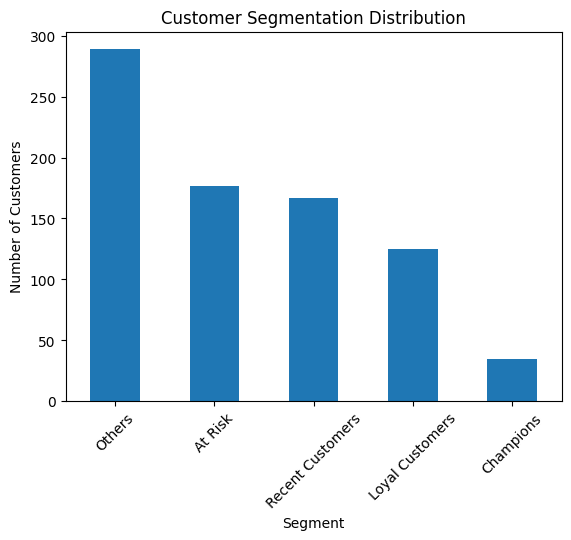

In [8]:
import matplotlib.pyplot as plt

rfm["Segment"].value_counts().plot(kind="bar")
plt.title("Customer Segmentation Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)

plt.savefig("../images/Custoer_Segmentation_Distribution.png", dpi=300, bbox_inches="tight")

plt.show()

## Revenue Contribution by Customer Segment

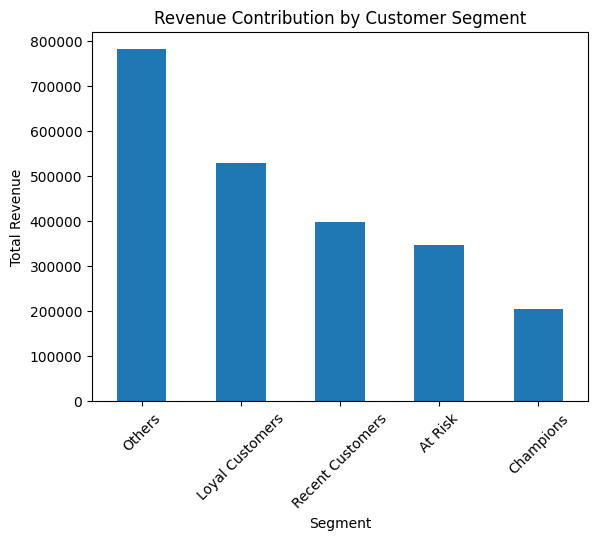

In [9]:
segment_revenue = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)

segment_revenue.plot(kind="bar")
plt.title("Revenue Contribution by Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)

plt.savefig("../images/Revenue_Contribution_by_Customer_Segment.png", dpi=300, bbox_inches="tight")

plt.show()


### 📊 What Your Revenue Chart Shows

From highest to lowest revenue:

Others ≈ 780k

Loyal Customers ≈ 530k

Recent Customers ≈ 400k

At Risk ≈ 350k

Champions ≈ 200k

## INSIGHTS : 
🧠 Important Insight #1 (Very Critical)
“Others” generate the most revenue.

This tells us something very important:

Your “Others” group is too broad.

It likely contains:

Medium-value customers

Semi-loyal customers

Mixed behavior customers

👉 This is normal when segmentation rules are simple.

In a real company, we would refine segmentation further.


🧠 Important Insight #2
Loyal Customers generate strong revenue (≈ 530k)

This is GOOD.

It means:

Frequent buyers = strong revenue base

Loyalty programs are working (hypothetically)

Business action:
→ Upsell premium products
→ Offer bundle deals


🧠 Important Insight #3
At Risk customers still contribute 350k revenue ⚠

This is huge.

If these customers churn:
→ Company could lose 350k revenue.

Business action:

Re-engagement campaigns

Targeted discounts

Reminder emails


🧠 Important Insight #4

Champions revenue is lower than expected (~200k)

Why?

Because:

Only 35 customers are Champions

Small group, even if high value

This is realistic.

## Revenue Contribution

In [10]:
segment_percentage = (
    rfm.groupby("Segment")["Monetary"].sum() /
    rfm["Monetary"].sum()
) * 100

segment_percentage.sort_values(ascending=False)


Segment
Others              34.577269
Loyal Customers     23.392603
Recent Customers    17.642565
At Risk             15.336939
Champions            9.050625
Name: Monetary, dtype: float64

In [11]:
rfm.to_csv("../data/processed/rfm_table.csv")


### 🧠 Executive-Level Interpretation (Business recommendations)

1️⃣ Others (34.6%) – Largest Revenue Base

This group generates the highest revenue share.

This indicates:

A broad mid-value customer base

Opportunity to convert them into Loyal or Champions

👉 Strategy: Targeted upselling & engagement campaigns



2️⃣ Loyal Customers (23.4%) – Strong Revenue Core

Nearly ¼ of total revenue comes from loyal buyers.

This is your stable business engine.

👉 Strategy:

Loyalty rewards

Membership perks

Cross-selling premium products




3️⃣ Recent Customers (17.6%) – Growth Opportunity

This segment represents future potential.

If nurtured properly:
They can become Loyal Customers.

👉 Strategy:

Onboarding offers

Personalized recommendations

Follow-up marketing



4️⃣ At Risk (15.3%) – Revenue Danger Zone ⚠

This is critical.

Over 15% of total revenue is tied to customers likely to churn.

If lost:
Significant revenue decline.

👉 Strategy:

Re-engagement emails

Discount incentives

Win-back campaigns



5️⃣ Champions (9.0%) – High Value, Low Volume

Only 35 customers, yet 9% of revenue.

That is powerful.

👉 Strategy:

VIP treatment

Early product access

Exclusive offers

# 🎯 Conclusion :

Although Champions represent a small portion of customers, they generate high per-customer value. Meanwhile, At Risk customers account for over 15% of total revenue, highlighting the importance of proactive retention strategies. The largest revenue share comes from the broad “Others” segment, indicating potential opportunity for further refinement and targeted engagement.

## Advanced Segments 

In [12]:
# 1. Creating Total RFM Score
rfm["RFM_Total"] = (
    rfm["R_score"].astype(int) +
    rfm["F_score"].astype(int) +
    rfm["M_score"].astype(int)
)


In [13]:
rfm["RFM_Total"].describe()


count    793.000000
mean       7.503153
std        2.525187
min        3.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       12.000000
Name: RFM_Total, dtype: float64

In [14]:
# 2.Creating Advanced Segments
def advanced_segment(score):
    if score >= 10:
        return "Champions"
    elif score >= 8:
        return "Loyal Customers"
    elif score >= 6:
        return "Potential Loyalists"
    elif score >= 4:
        return "At Risk"
    else:
        return "Hibernating"

rfm["Advanced_Segment"] = rfm["RFM_Total"].apply(advanced_segment)


In [15]:
rfm["Advanced_Segment"].value_counts()


Advanced_Segment
Loyal Customers        212
Champions              201
Potential Loyalists    183
At Risk                140
Hibernating             57
Name: count, dtype: int64

In [16]:
rfm.groupby("Advanced_Segment")["Monetary"].sum().sort_values(ascending=False)


Advanced_Segment
Champions              944677.6268
Loyal Customers        771826.3131
Potential Loyalists    361098.7097
At Risk                156604.2744
Hibernating             27329.8587
Name: Monetary, dtype: float64

In [17]:
rfm.to_csv("../data/processed/rfm_table.csv", index=False)


## 🧠 Interpretation

#### 🥇 Champions = 944k (Highest Revenue)

Now this makes business sense.

Your top segment is truly your highest revenue driver.

This shows your improved segmentation logic is working properly.

#### 🥈 Loyal Customers = 771k

Strong, stable revenue foundation.

#### 🌱 Potential Loyalists = 361k

Huge growth opportunity.

This is your upsell segment.

#### ⚠ At Risk = 156k

Revenue at danger.

Lower than before (good sign — segmentation refined).

#### 💤 Hibernating = 27k

Very low value.
Low retention priority.

## 🎯 Business Strategy Section (Add This)

#### Strategic Actions

1. Protect Champions with VIP programs and early ac cess offers.
 
2. Increase CLV of Loyal Customers through cr oss-selling.
 
3. Convert Potential Loyalists into Loyal via targeted ca mpaigns.
 
4. Run win-back campaigns for At Risk customers.
 
5. Minimal investment in Hibernating segment.